In [1]:
library(forecast)
library(ggplot2)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff


In [2]:
library(readr)
# Reading data created in Python Energy_Demand_Forecasting_ARIMA
data = read_csv("C:/Users/afotina/PycharmProjects/Time_Series/Data/Energy_NY_Daily.csv")
head(data)

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_date(format = ""),
  demand = col_double(),
  precip = col_double(),
  min_temp = col_double(),
  max_temp = col_double(),
  avg_temp = col_double()
)


X1,demand,precip,min_temp,max_temp,avg_temp
2012-01-01,118916.0,0.0597,38.78,50.77,46.51000
2012-01-02,127270.9,0.0000,33.57,49.78,40.49667
2012-01-03,146292.3,0.0000,16.47,33.14,26.67250
2012-01-04,152070.4,0.0000,13.40,31.83,20.58500
2012-01-05,147125.9,0.0000,27.31,39.16,33.57750
2012-01-06,140820.9,0.0000,33.66,51.94,43.40083


# Univariate ETS, TBATS, ARIMA

In [3]:
# UNIVARIATE TS
demand = msts(data['demand'], start = c(2012,1), seasonal.periods=c(7,365.25))

Warning message in periods * seq(-20:20):
"longer object length is not a multiple of shorter object length"

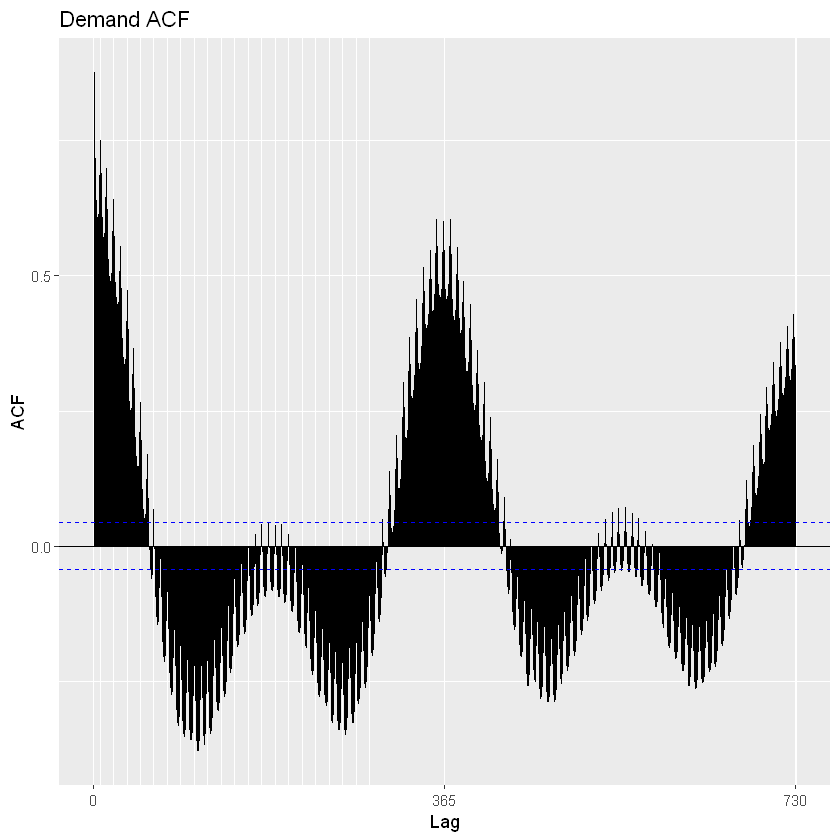

In [4]:
# ACF
ggAcf(demand) + ggtitle("Demand ACF")

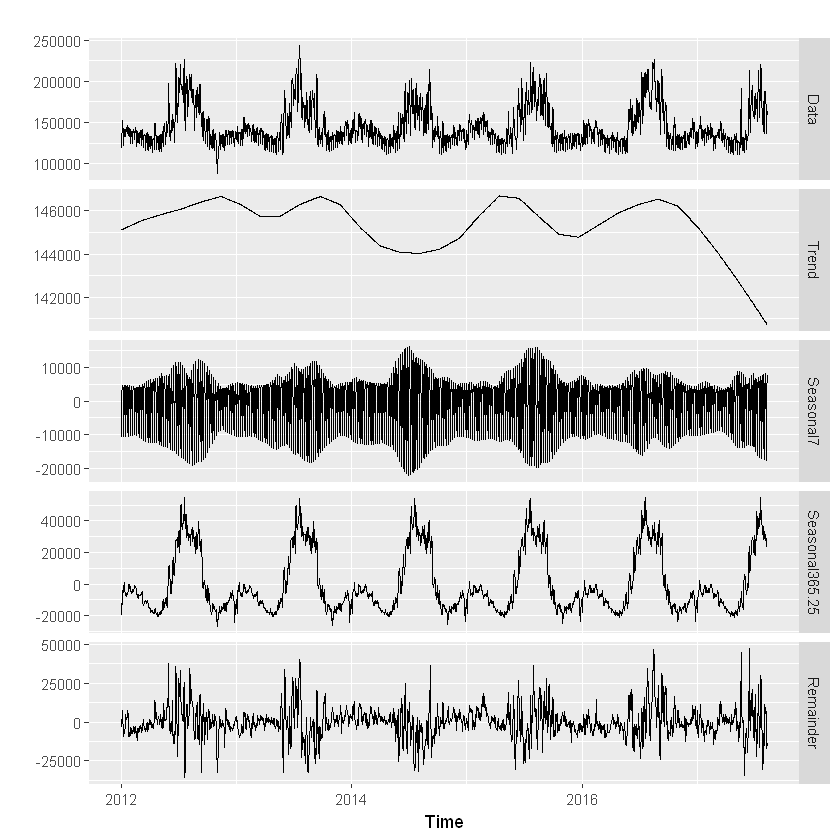

In [5]:
demand %>% mstl() %>% autoplot()

In [6]:
train = window(demand, end = c(2017,183))
test = window(demand, start = c(2017,184))
print(nrow(train))
print(nrow(test))

[1] 2008
[1] 40


## ETS

Warning message in ets(train):
"I can't handle data with frequency greater than 24. Seasonality will be ignored. Try stlf() if you need seasonal forecasts."Warning message in ets(.):
"I can't handle data with frequency greater than 24. Seasonality will be ignored. Try stlf() if you need seasonal forecasts."

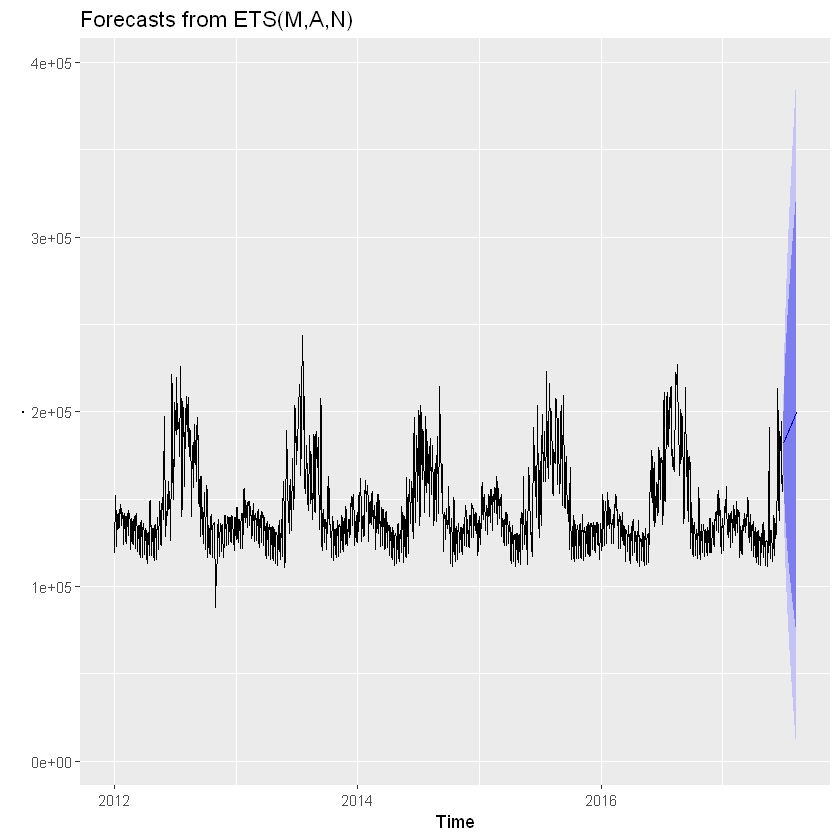

In [7]:
# ETS ignores frequency higher than 24
model_ets = ets(train)
fc_ets = forecast(model_ets, h = nrow(test))
train %>% ets() %>% forecast(h=nrow((test))) %>% autoplot()


	Ljung-Box test

data:  Residuals from ETS(M,A,N)
Q* = 53989, df = 398, p-value < 2.2e-16

Model df: 4.   Total lags used: 402



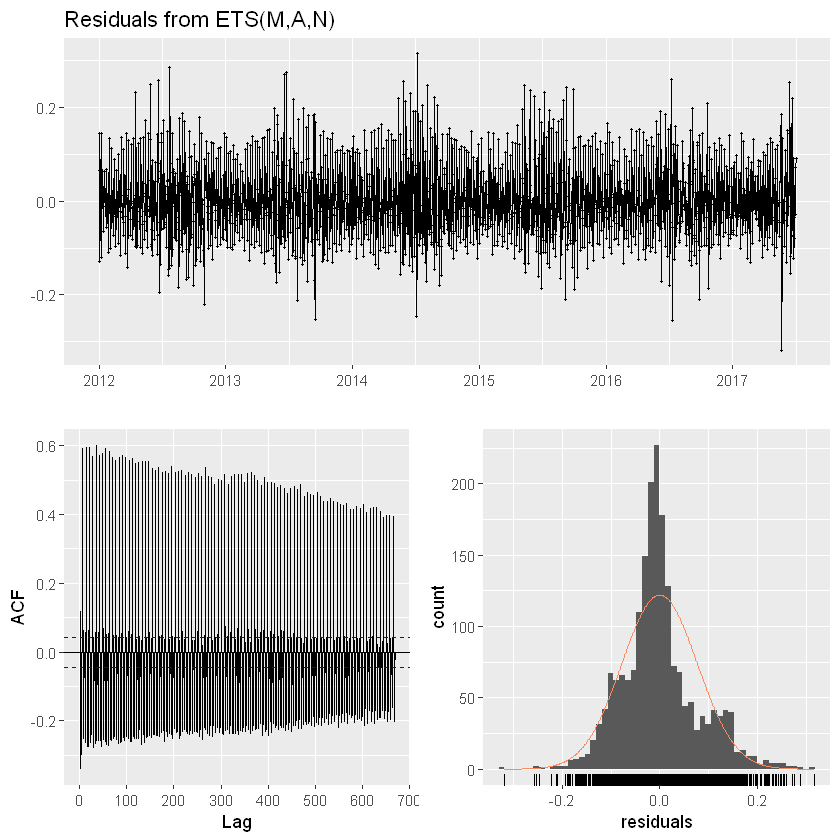

In [8]:
# Check residuals

# Essential assumptions:
# - they should be uncorrelated (95% of all ACF should lie withing the blue lines)
# - they should have mean zero

# Useful properties:
# - they should have constant variance
# - they should be normally distributed

# Ljung-Box test considers first h autocorrelation values together. 
# A small p-value indicates the series is probably not white noise. 

checkresiduals(fc_ets)

In [9]:
accuracy(fc_ets, test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-471.7268,11494.03,8272.125,-0.6260368,5.642561,0.6584607,0.1417711,NA
Test set,-17312.7511,28740.58,24342.977,-11.6678509,15.010301,1.9376997,0.7031805,1.740356


## TBATS

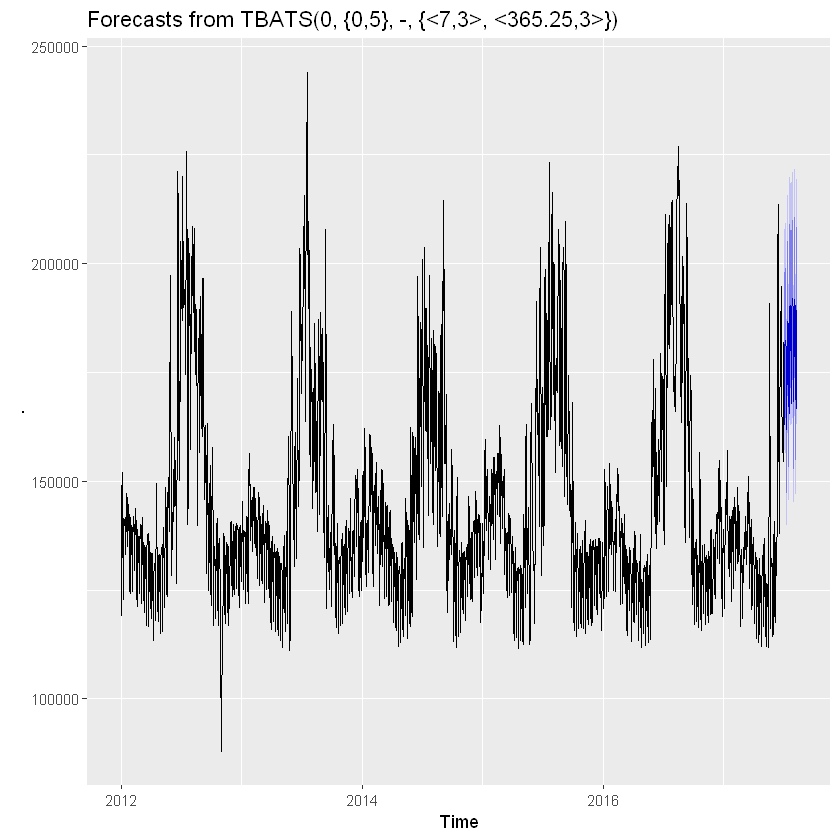

In [10]:
# TBATS can hanlde long and/or multi-seasonality/frequency
model_tbats = tbats(train)
fc_tbats = forecast(model_tbats, h = nrow(test))
train %>% tbats() %>% forecast(h=nrow(test)) %>% autoplot()

In [11]:
model_tbats

TBATS(0, {0,5}, -, {<7,3>, <365.25,3>})

Call: tbats(y = train)

Parameters
  Lambda: 0
  Alpha: 0.01570968
  Gamma-1 Values: -0.0001169308 -4.680823e-06
  Gamma-2 Values: 2.221738e-05 3.03794e-05
  MA coefficients: 1.024483 0.693312 0.364295 0.156249 0.065615

Seed States:
              [,1]
 [1,] 11.857006772
 [2,] -0.057651986
 [3,] -0.027737060
 [4,] -0.006939573
 [5,]  0.025149365
 [6,]  0.023475775
 [7,]  0.010665295
 [8,] -0.105867380
 [9,]  0.073632594
[10,] -0.007387256
[11,] -0.053769334
[12,]  0.095668606
[13,] -0.018982980
[14,]  0.000000000
[15,]  0.000000000
[16,]  0.000000000
[17,]  0.000000000
[18,]  0.000000000
attr(,"lambda")
[1] 3.337961e-07

Sigma: 0.04417991
AIC: 50484.33

In [12]:
# TBATS(0, {0,5}, -, {<7,3>, <365.25,3>})
# Params:
# 0: BoxCos lambda
# {0,5}: ARMA p and q
# -: trend damping parameter (none here)
# <7,3>: seasonal period of 7, fourier K=3
# <365.25,3>: seasonal period of 365.25, fourier K=3


	Ljung-Box test

data:  Residuals from TBATS
Q* = 432.02, df = 373, p-value = 0.01875

Model df: 29.   Total lags used: 402



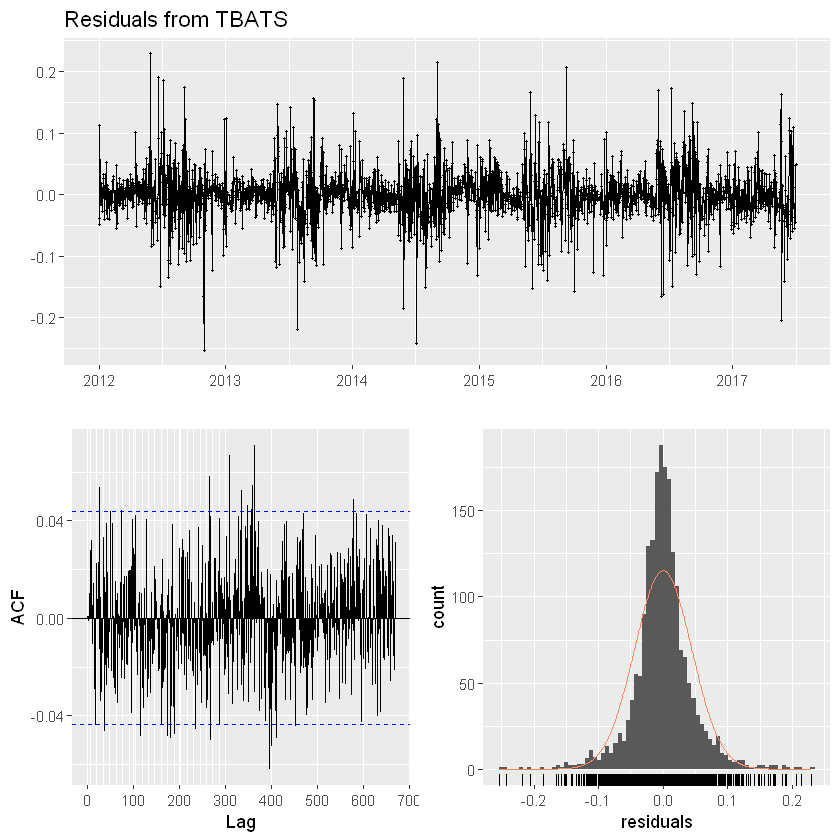

In [13]:
checkresiduals(model_tbats)

In [14]:
accuracy(fc_tbats, test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,157.3644,7004.943,4581.596,-0.08867236,3.019458,0.3646948,0.02504658,NA
Test set,-7571.2881,20335.783,16474.420,-5.57372262,9.887193,1.3113629,0.73828802,1.209679


## ARIMA

In [15]:
# TS with frequency=7
demand7 = ts(data['demand'], frequency=7)
train7 = window(demand7, end = c(287,6)) # week 287, day 6 (evntually run tail(demand7) in RStudio to check the start/end)
test7 = window(demand7, start = c(287,7))
print(nrow(train7))
print(nrow(test7))

[1] 2008
[1] 40


In [16]:
# TS with frequency=365.25
demand365 = ts(data['demand'], start = c(2012,1), frequency=365.25)
train365 = window(demand365, end = c(2017,182))
test365 = window(demand365, start = c(2017,183))
print(nrow(train7))
print(nrow(test7))

[1] 2008
[1] 40


### Simple Auto-ARIMA

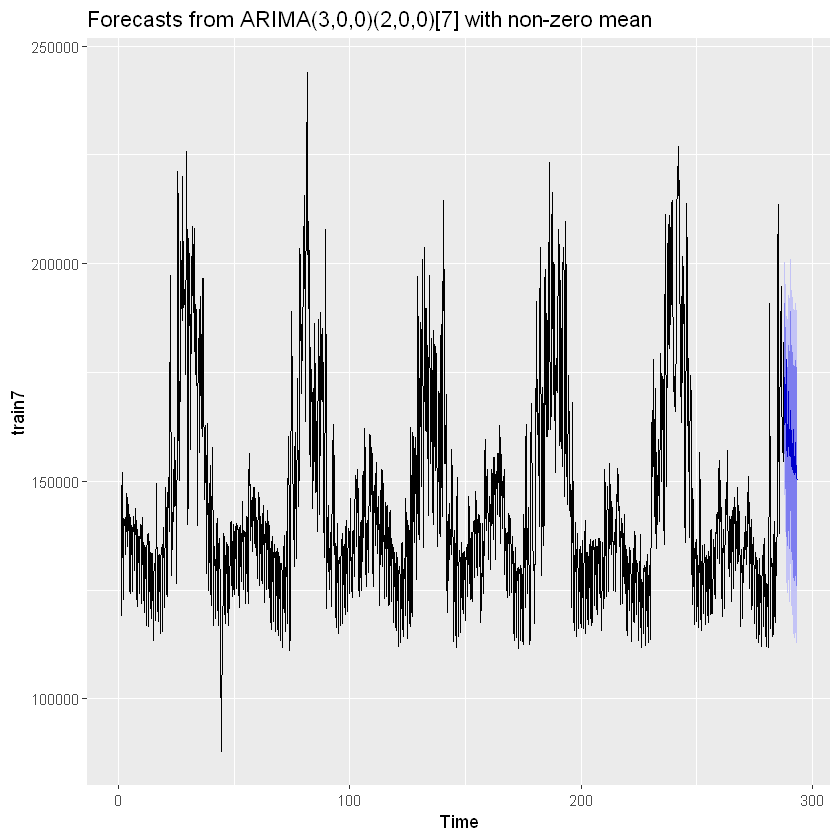

In [17]:
# SIMPLE AUTO-ARIMA
# Frequency 7. Freq 365 is not supported (too heavy)
model_arima7 = auto.arima(train7)
model_arima7 %>% forecast(h=nrow(test7)) %>% autoplot()


	Ljung-Box test

data:  Residuals from ARIMA(3,0,0)(2,0,0)[7] with non-zero mean
Q* = 102.87, df = 8, p-value < 2.2e-16

Model df: 6.   Total lags used: 14



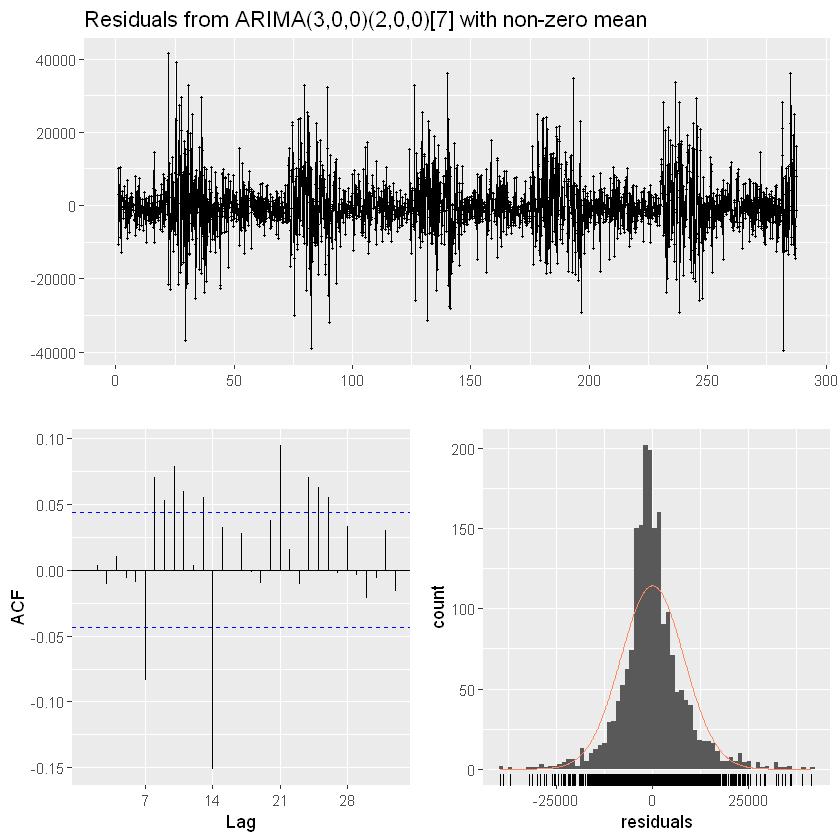

In [18]:
checkresiduals(model_arima7)

In [19]:
accuracy(forecast(model_arima7, h = nrow(test)), test7)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,32.86666,8233.375,5667.25,-0.2801965,3.749385,0.5348261,-0.00104113,NA
Test set,14975.12846,25718.235,18690.36,7.3791002,9.915288,1.7638350,0.69007510,1.314115


### Auto-ARIMA with Fourier seasonality

In [54]:
# Finding K
bestfit = list(aicc=Inf)
for (k in 1:10){
    bestfit = list(aicc=Inf)
    fit = auto.arima(train7, xreg = fourier(train365, K=k), seasonal = TRUE)
    #fit = auto.arima(train7, xreg = fourier(train7, K=k), seasonal = FALSE)
    if(fit$aicc < bestfit$aicc)
        bestfit = fit
    else break;
}
     
print(paste0('The optmal number of Fourier terms is: ', k))
print(bestfit$aicc)

[1] "The optmal number of Fourier terms is: 10"
[1] 41770.37


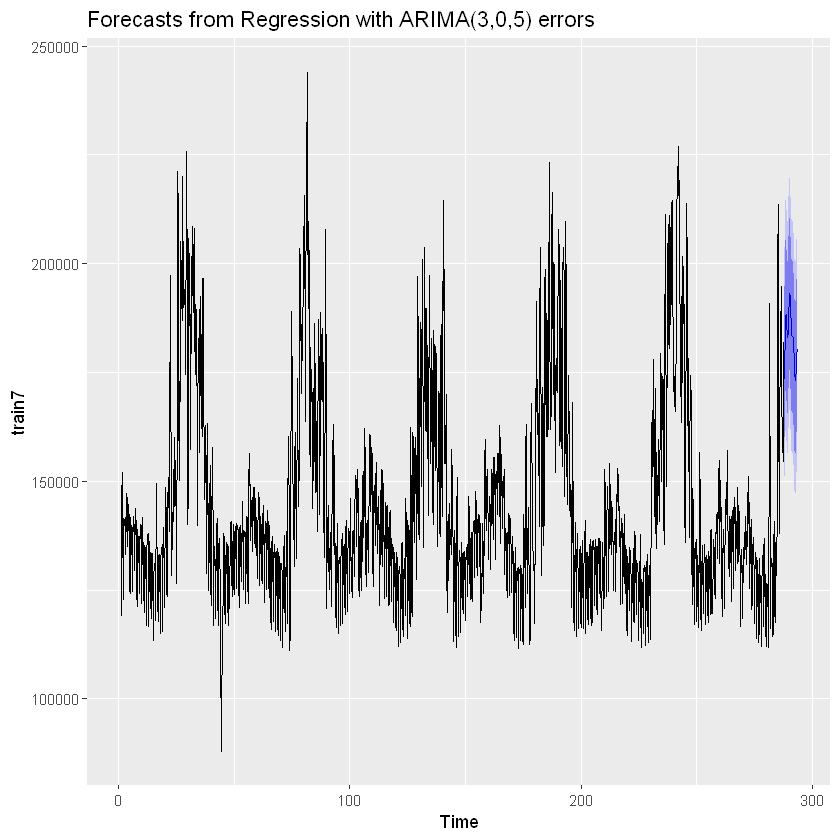

In [51]:
fc = forecast(bestfit, xreg = fourier(train365, K=k, h=nrow(test7)))
#fc = forecast(bestfit, xreg = fourier(train7, K=k, h=nrow(test7)))
fc %>% autoplot()


	Ljung-Box test

data:  Residuals from Regression with ARIMA(3,0,5) errors
Q* = 3869.9, df = 3, p-value < 2.2e-16

Model df: 79.   Total lags used: 82



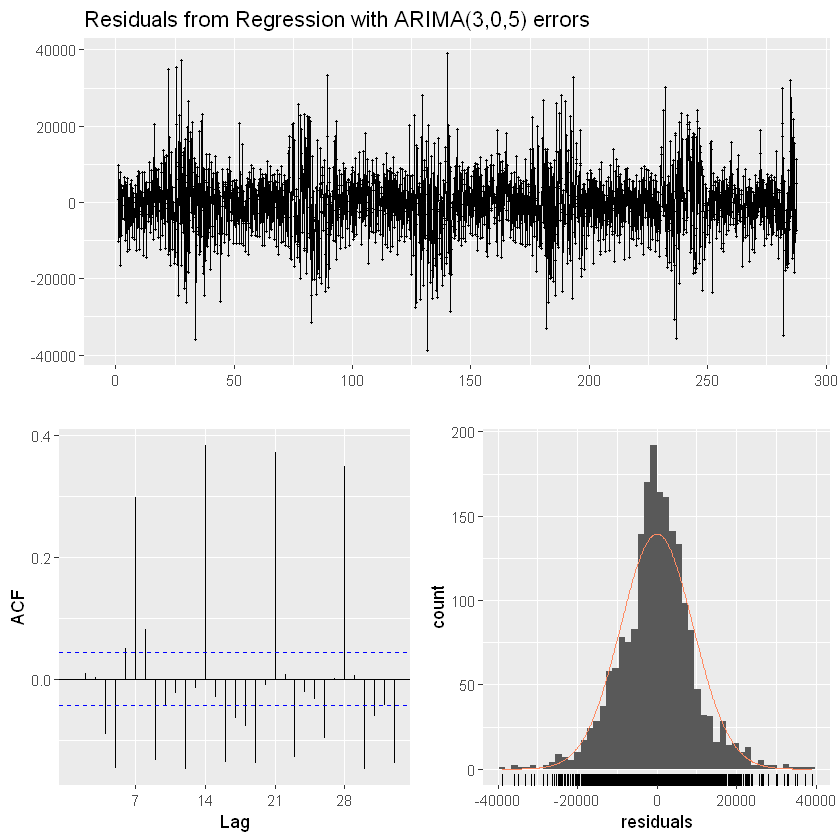

In [52]:
checkresiduals(bestfit)

In [53]:
accuracy(fc, test7)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,10.72359,9131.777,6786.349,-0.3422138,4.61132,0.6404371,0.0001475637,NA
Test set,-9079.38884,22168.457,19383.788,-6.6593617,11.73275,1.8292747,0.6169831984,1.299313


In [ ]:
#SEASONAL = TRUE, 10 Fourier terms for train365
#MAPE 3.54, 11.34
#RMSE 7804, 21702

#SEASONAL = FALSE, 10 Fourier terms for train365
#MAPE 4.77, 11.52
#RMSE 9468, 21993

#SEASONAL = FALSE, 3 Fourier terms for train7
#MAPE 3.15, 9.81
#RMSE 7295, 21704


## Auto-ARIMA with covariates

In [61]:
# Covariates
data_train = data[1:2008, 4:6]
data_test = data[2009:nrow(data), 4:6]
print(nrow(data_train))
print(nrow(data_test))
head(data_train,5)

[1] 2008
[1] 40


min_temp,max_temp,avg_temp
38.78,50.77,46.51000
33.57,49.78,40.49667
16.47,33.14,26.67250
13.40,31.83,20.58500
27.31,39.16,33.57750


Warning message in forecast.Arima(model_arima7_cov, xreg = xreg_test, h = nrow(test7)):
"xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order."

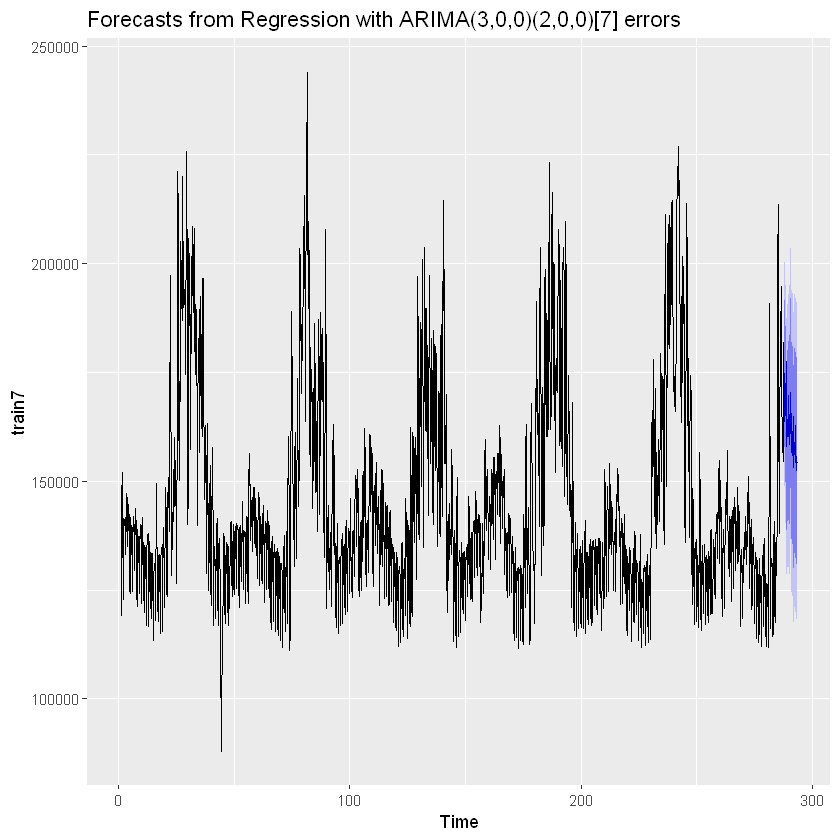

In [73]:
# Simple with covariates
xreg_train = cbind(data_train[['min_temp']], data_train[['max_temp']], data_train[['avg_temp']])
xreg_test = cbind(data_test[['min_temp']], data_test[['max_temp']], data_test[['avg_temp']])
model_arima7_cov = auto.arima(train7, xreg = xreg_train)
fc = forecast(model_arima7_cov, xreg = xreg_test, h = nrow(test7))
fc %>% autoplot()


	Ljung-Box test

data:  Residuals from Regression with ARIMA(3,0,0)(2,0,0)[7] errors
Q* = 91.047, df = 5, p-value < 2.2e-16

Model df: 9.   Total lags used: 14



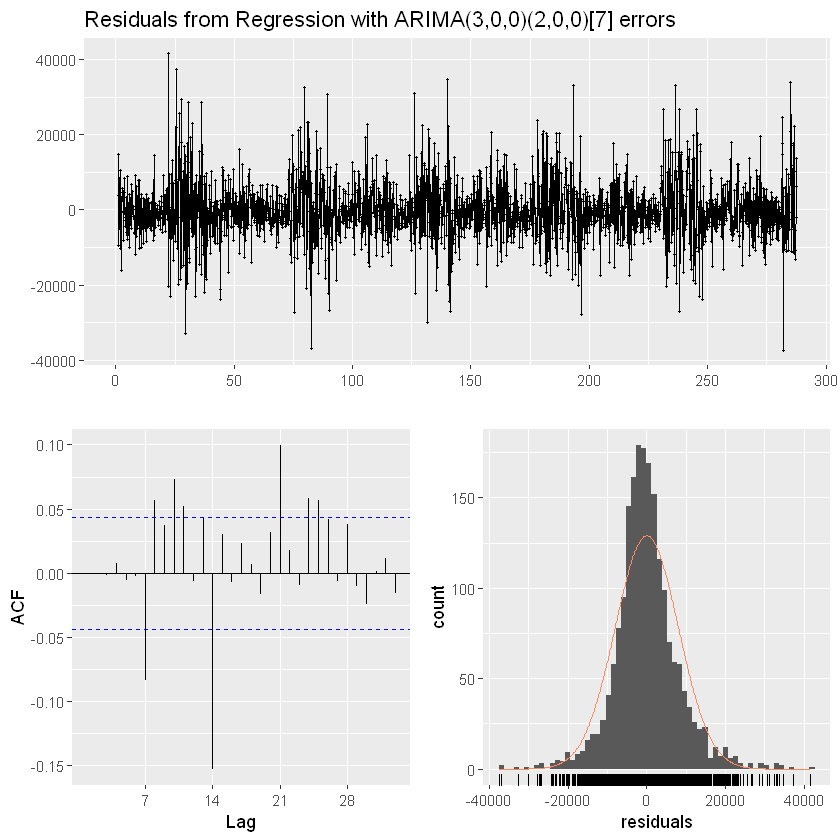

In [74]:
checkresiduals(model_arima7_cov)

In [75]:
accuracy(fc,test7)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,23.99848,8044.782,5772.579,-0.2771088,3.859002,0.5447662,-0.0001190492,NA
Test set,12430.06002,23206.547,16871.502,5.9617668,8.988091,1.5921868,0.6916266944,1.185148


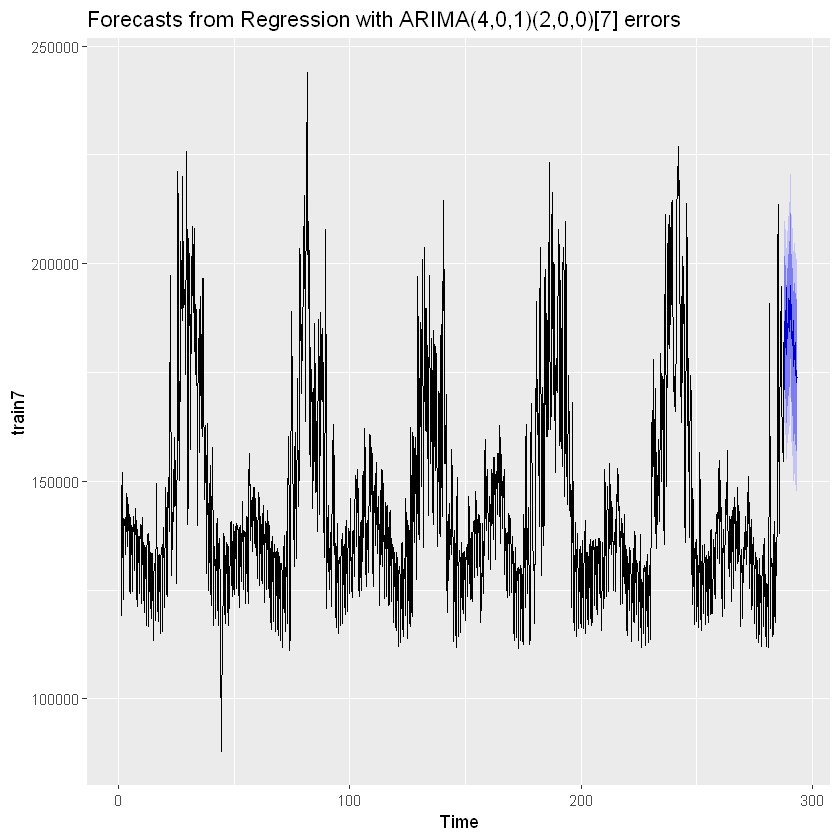

In [79]:
# Fourier and covariates
# k=10 defined above
model_arima_cov2 = auto.arima(train7, xreg = cbind(fourier(train365, K=10), xreg_train), seasonal = TRUE)
fc = forecast(model_arima_cov2, xreg = cbind(fourier(train365, K=10, h=nrow(test7)), xreg_test))
fc %>% autoplot()


	Ljung-Box test

data:  Residuals from Regression with ARIMA(4,0,1)(2,0,0)[7] errors
Q* = 122.83, df = 3, p-value < 2.2e-16

Model df: 31.   Total lags used: 34



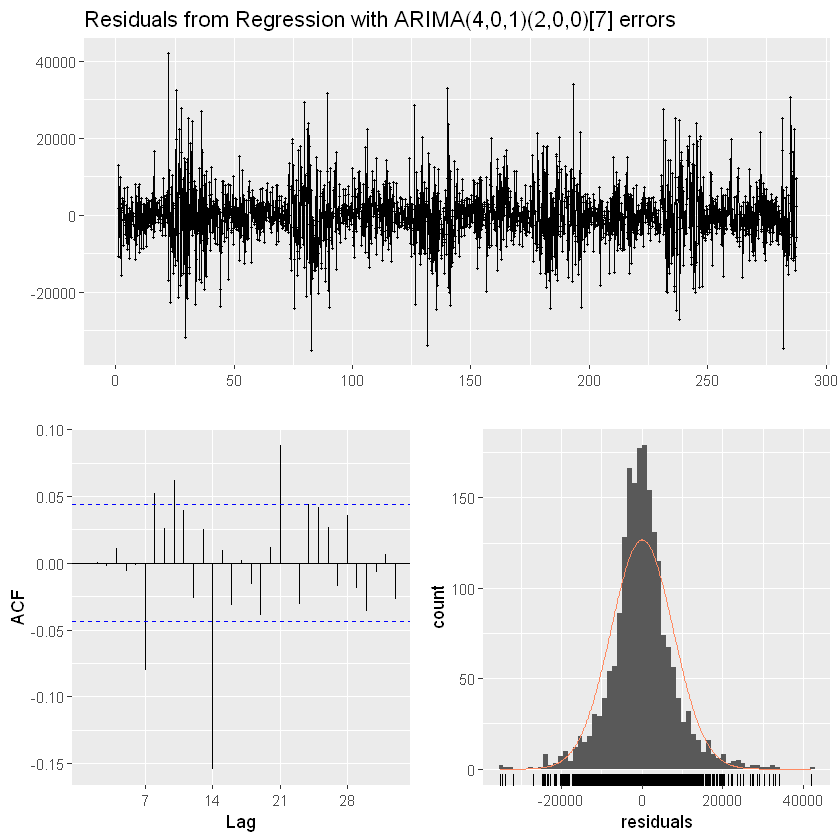

In [80]:
checkresiduals(model_arima_cov2)

In [81]:
accuracy(fc, test7)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,4.766706,7753.008,5540.075,-0.2414211,3.706159,0.5228245,-0.00011391,NA
Test set,-8656.082960,20532.275,17711.206,-6.2962448,10.696537,1.6714309,0.65539918,1.197761


# Results

In [85]:
models = list(model_tbats, model_arima7, bestfit, model_arima7_cov, model_arima_cov2)
for (m in models)
    print(m$aicc)

#Tbats has no aicc

NULL
[1] 41926.64
[1] 41770.37
[1] 41839.46
[1] 41734.9


model_tbats has lowest RMSE of 20336 followed by model_arima_cov2 (both fourier for train365 and covariates) with RMSE of 20532.
This reslut is still worse that the one with Prophet where the same covariates gave RMSE of 17926. 